In [1]:
import sqlite3
import pandas as pd
import sklearn
from sklearn.model_selection import ShuffleSplit, train_test_split,cross_val_score,GridSearchCV,KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", con)

In [3]:
print(df.shape)
print(df.columns)

(183978, 42)
Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')


In [4]:
print(df.info())
print("As we can see from info of dataframe that there null values in different column")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [5]:
df.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [6]:
df.dropna(axis=0,inplace=True)
print('\n let see the distribution of every column')


 let see the distribution of every column


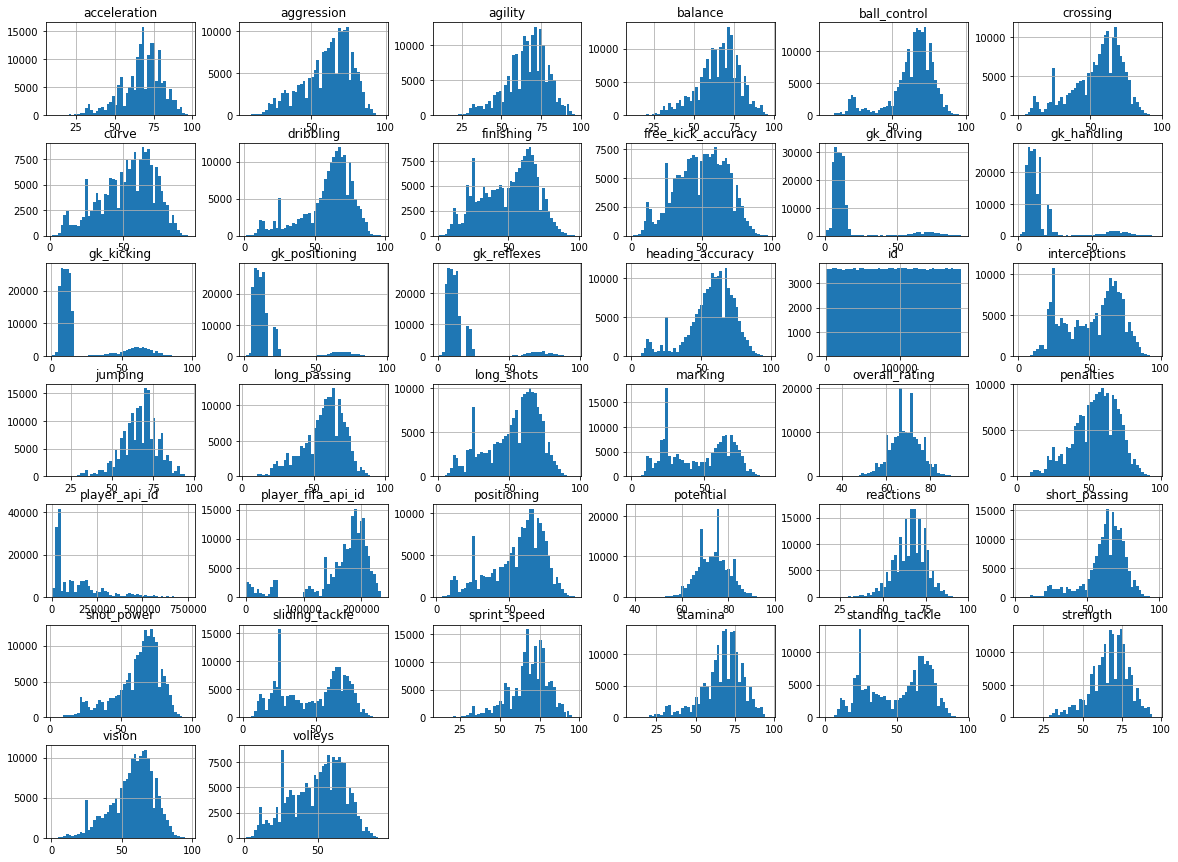


Lets see object data type:-
Index(['date', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate'], dtype='object')
medium    125070
high       42823
low         8569
None        3317
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64
I guess these columns could play vitual role in prediction so lets convert these categories


In [7]:
df.hist(bins=50,figsize=(20,15))
plt.show()
print('\nLets see object data type:-')
Category= df.select_dtypes(include=['object']).columns
print(Category)
print(df.attacking_work_rate.value_counts())
print("I guess these columns could play vitual role in prediction so lets convert these categories")

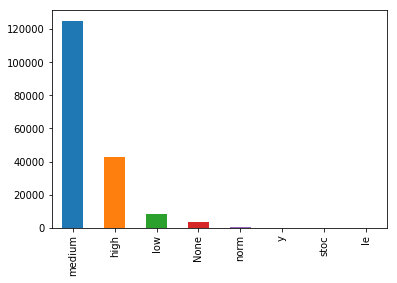

In [8]:
# for clear insite Plotting the distribution of the values in the attacking_work_rate column
df["attacking_work_rate"].value_counts().plot.bar()

medium    125070
high       42823
low        12461
Name: attacking_work_rate, dtype: int64


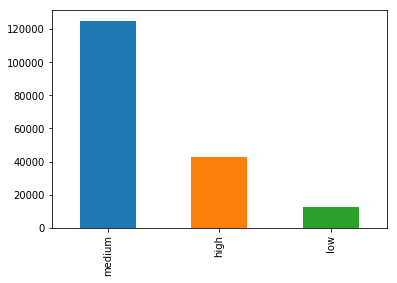

In [9]:
# Choosing to replace only with low because it can improve the variance of the column
df.replace( ['None','norm','y','stoc','le'],'low', inplace = True)
print(df["attacking_work_rate"].value_counts())
df["attacking_work_rate"].value_counts().plot.bar()

In [10]:
print(df.defensive_work_rate.value_counts())

medium    130846
high       27041
low        18432
o           1328
1            421
2            334
ormal        317
3            243
5            231
7            207
0            188
6            179
9            143
4            116
es            94
tocky         86
ean           78
8             70
Name: defensive_work_rate, dtype: int64


medium    131372
high       27461
low        21521
Name: defensive_work_rate, dtype: int64


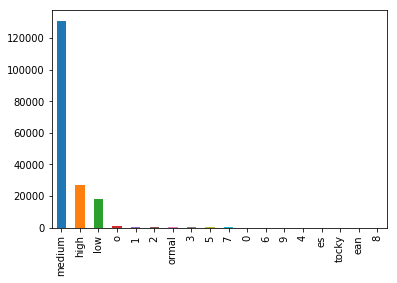

In [11]:
df["defensive_work_rate"].value_counts().plot.bar()
df.replace(['o', '1', '2', 'ormal', '3', '0', 'es', 'tocky', 'ean'],'low',inplace = True) 
df.replace(['5',  '6', '4'],'medium', inplace = True) 
df.replace([ '7', '9', '8'],'high', inplace = True) 
print(df["defensive_work_rate"].value_counts())

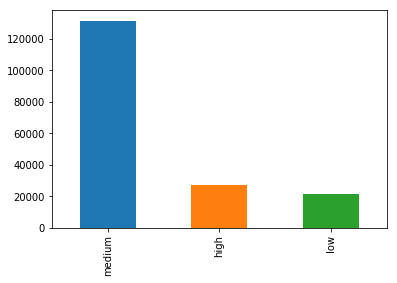

In [12]:
df["defensive_work_rate"].value_counts().plot.bar()

In [13]:
import seaborn as sns

In [14]:
plt.figure(figsize=(5,5))

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

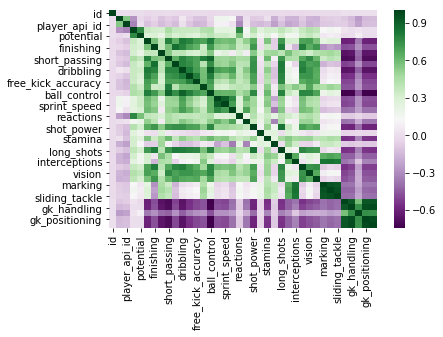

In [15]:
sns.heatmap(df.corr(), cmap="PRGn")

In [16]:
df.corr().loc['overall_rating']
print("\n overall_rating is highly correlated with the reactions and potential columns(Correlation>0.7). It is moderately correlated with short_passing, long_passing,ball_control, shot_power,vision (correlation >0.4")


 overall_rating is highly correlated with the reactions and potential columns(Correlation>0.7). It is moderately correlated with short_passing, long_passing,ball_control, shot_power,vision (correlation >0.4


In [17]:
print("\nLet Prepare X and Y for Model")
#Prepare X first 
X = df.drop("overall_rating",axis = 1)
X.shape, X.columns


Let Prepare X and Y for Model


((180354, 41),
 Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
        'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
        'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
        'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
        'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
        'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
       dtype='object'))

In [18]:
#Convert Data Column for better understanding 
X['year'] = pd.DatetimeIndex(X.date).year
X['month'] = pd.DatetimeIndex(X.date).month
X['day'] = pd.DatetimeIndex(X.date).day
X.drop('date',axis=1, inplace=True)

In [19]:
# Now Converting all Columns to Numerical for the shake of anaylisis
X_cat_cols = X.select_dtypes(include='object').columns.tolist()
X_cat_cols

['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

In [20]:
# LabelEncoding the preferred_foot, attacking_work_rate, defensive_work_rate
from sklearn.preprocessing import LabelEncoder
for i in X_cat_cols:
    lbl_enc = LabelEncoder()
    X[i] = lbl_enc.fit_transform(X[i])

In [21]:
#Final Look to X variable 
# Checking the columns and the shape of the input vector after encoding
X.columns, X.shape 

(Index(['id', 'player_fifa_api_id', 'player_api_id', 'potential',
        'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
        'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
        'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
        'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
        'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'year',
        'month', 'day'],
       dtype='object'), (180354, 43))

In [22]:
# its turn for Y 
Y = df["overall_rating"]
Y.shape

(180354,)

In [23]:
print("\nSpliting test and train sets 25%")
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, random_state = 100)
import math
print("\n Creating a model and checking model Score \n")
lm  = LinearRegression()
model  = lm.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)


Spliting test and train sets 25%

 Creating a model and checking model Score 



In [24]:
print('Linear Regression -', 'RMSE Train:', math.sqrt(mean_squared_error(y_train_pred, y_train)))
print('Linear Regression -', 'RMSE Test:' ,math.sqrt(mean_squared_error(y_test_pred, y_test)))  
print('Linear Regression -', 'R2_score Train:', r2_score(y_train_pred, y_train))
print('Linear Regression -', 'R2_score Test:' ,r2_score(y_test_pred, y_test))

Linear Regression - RMSE Train: 2.4865828726596617
Linear Regression - RMSE Test: 2.4908594258832584
Linear Regression - R2_score Train: 0.8564720600523772
Linear Regression - R2_score Test: 0.85670263865022


In [25]:
regressors = [
            ("Linear - ", LinearRegression(normalize=True)),
            ("Ridge - ",  Ridge(alpha=0.5, normalize=True)),
            ("Lasso - ",  Lasso(alpha=0.5, normalize=True)),
            ("ElasticNet - ",  ElasticNet(alpha=0.5, l1_ratio=0.5, normalize=True)),
            ("Decision Tree - ",  DecisionTreeRegressor(max_depth=5)),
            ("Random Forest - ",  RandomForestRegressor(n_estimators=5)),
            ("AdaBoost - ",  AdaBoostRegressor(n_estimators=5)),
            ("GBM - ", GradientBoostingRegressor(n_estimators=5))]

In [26]:
for reg in regressors:
    reg[1].fit(x_train, y_train)
    y_test_pred= reg[1].predict(x_test)
    print(reg[0],"\n\t R2-Score:", reg[1].score(x_test, y_test),
                 "\n\t RMSE:", math.sqrt(mean_squared_error(y_test_pred, y_test)),"\n")

Linear -  
	 R2-Score: 0.8753631121241854 
	 RMSE: 2.4908594258832584 

Ridge -  
	 R2-Score: 0.8322696803400622 
	 RMSE: 2.889559938694759 

Lasso -  
	 R2-Score: -4.220879563199276e-06 
	 RMSE: 7.0554844132901415 

ElasticNet -  
	 R2-Score: -4.220879563199276e-06 
	 RMSE: 7.0554844132901415 

Decision Tree -  
	 R2-Score: 0.7830635206211316 
	 RMSE: 3.2861865524378087 

Random Forest -  
	 R2-Score: 0.9745168604432078 
	 RMSE: 1.1262955974955984 

AdaBoost -  
	 R2-Score: 0.7557485287290588 
	 RMSE: 3.4869403205124145 

GBM -  
	 R2-Score: 0.4566327593638615 
	 RMSE: 5.200829853475986 



In [27]:
print("\nfeature Selection using random forest \n")
rndf = RandomForestRegressor(n_estimators=10)
rndf.fit(x_train, y_train)


feature Selection using random forest 



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
importance = pd.DataFrame.from_dict({'cols':x_train.columns, 'importance': rndf.feature_importances_})
importance = importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(20,15))

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

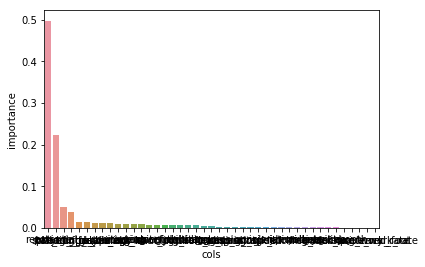

In [29]:
sns.barplot(importance.cols, importance.importance)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

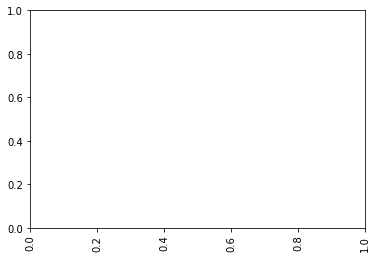

In [30]:
plt.xticks(rotation=90)

In [31]:
imp_cols = importance[importance.importance >= 0.005].cols.values
imp_cols

array(['reactions', 'potential', 'ball_control', 'standing_tackle',
       'player_fifa_api_id', 'heading_accuracy', 'gk_positioning',
       'gk_diving', 'player_api_id', 'positioning', 'marking', 'year',
       'crossing', 'gk_handling', 'strength', 'shot_power',
       'interceptions', 'finishing', 'dribbling', 'gk_reflexes'],
      dtype=object)

In [32]:
print("\nFitting models with columns where feature importance>=0.005\n")
x_train, x_test, y_train, y_test = train_test_split(X[imp_cols],Y,test_size=0.25, random_state = 100)


Fitting models with columns where feature importance>=0.005



In [33]:
for reg in regressors:
    reg[1].fit(x_train, y_train)
    y_test_pred= reg[1].predict(x_test)
    print(reg[0],"\n\t R2-Score:", reg[1].score(x_test, y_test),
                 "\n\t RMSE:", math.sqrt(mean_squared_error(y_test_pred, y_test)),"\n")

Linear -  
	 R2-Score: 0.8712772553304844 
	 RMSE: 2.531357975758788 

Ridge -  
	 R2-Score: 0.8278704342978989 
	 RMSE: 2.9272084941797862 

Lasso -  
	 R2-Score: -4.220879563199276e-06 
	 RMSE: 7.0554844132901415 

ElasticNet -  
	 R2-Score: -4.220879563199276e-06 
	 RMSE: 7.0554844132901415 

Decision Tree -  
	 R2-Score: 0.7830635206211316 
	 RMSE: 3.2861865524378087 

Random Forest -  
	 R2-Score: 0.9734512173708784 
	 RMSE: 1.149603893655698 

AdaBoost -  
	 R2-Score: 0.770496385357664 
	 RMSE: 3.380031013875091 

GBM -  
	 R2-Score: 0.45663275936386316 
	 RMSE: 5.200829853475978 



In [34]:
imp_cols = importance[importance.importance >= 0.001].cols.values
imp_cols

array(['reactions', 'potential', 'ball_control', 'standing_tackle',
       'player_fifa_api_id', 'heading_accuracy', 'gk_positioning',
       'gk_diving', 'player_api_id', 'positioning', 'marking', 'year',
       'crossing', 'gk_handling', 'strength', 'shot_power',
       'interceptions', 'finishing', 'dribbling', 'gk_reflexes',
       'stamina', 'short_passing', 'aggression', 'long_passing',
       'long_shots', 'sliding_tackle', 'sprint_speed', 'vision',
       'acceleration', 'id', 'gk_kicking', 'jumping', 'penalties',
       'volleys', 'curve', 'balance', 'agility', 'free_kick_accuracy'],
      dtype=object)

In [35]:
print("\nFitting models with columns where feature importance>=0.001\n")
x_train, x_test, y_train, y_test = train_test_split(X[imp_cols],Y,test_size=0.25, random_state = 100)


Fitting models with columns where feature importance>=0.001



In [36]:
for reg in regressors:
    reg[1].fit(x_train, y_train)
    y_test_pred= reg[1].predict(x_test)
    print(reg[0],"\n\t R2-Score:", reg[1].score(x_test, y_test),
                 "\n\t RMSE:", math.sqrt(mean_squared_error(y_test_pred, y_test)),"\n")

Linear -  
	 R2-Score: 0.8747888410034347 
	 RMSE: 2.496591215040614 

Ridge -  
	 R2-Score: 0.8315715523218906 
	 RMSE: 2.8955671651411694 

Lasso -  
	 R2-Score: -4.220879563199276e-06 
	 RMSE: 7.0554844132901415 

ElasticNet -  
	 R2-Score: -4.220879563199276e-06 
	 RMSE: 7.0554844132901415 

Decision Tree -  
	 R2-Score: 0.7830635206211316 
	 RMSE: 3.2861865524378087 

Random Forest -  
	 R2-Score: 0.9752198721173548 
	 RMSE: 1.1106512043471826 

AdaBoost -  
	 R2-Score: 0.7690048176273857 
	 RMSE: 3.3909968113533826 

GBM -  
	 R2-Score: 0.4566327593638626 
	 RMSE: 5.20082985347598 



In [37]:
print("\nRandomForest and GBM provide us with the best RMSE and R2-Score when selecting columns with feature importance >= 0.001\n")


RandomForest and GBM provide us with the best RMSE and R2-Score when selecting columns with feature importance >= 0.001



In [38]:
print("\nValidating our models using K-Fold Cross Validation for Robustness\n")


Validating our models using K-Fold Cross Validation for Robustness



In [39]:
scoring = 'neg_mean_squared_error'

In [40]:
results=[]
names=[]

In [41]:
for modelname, model in regressors:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, x_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(modelname)
    print(modelname,"\n\t CV-Mean:", cv_results.mean(),
                    "\n\t CV-Std. Dev:",  cv_results.std(),"\n")

Linear -  
	 CV-Mean: -6.215925595752932 
	 CV-Std. Dev: 0.07649486185720171 

Ridge -  
	 CV-Mean: -8.292970128724052 
	 CV-Std. Dev: 0.12624072167664105 

Lasso -  
	 CV-Mean: -49.263172179987876 
	 CV-Std. Dev: 0.5729685439130466 

ElasticNet -  
	 CV-Mean: -49.263172179987876 
	 CV-Std. Dev: 0.5729685439130466 

Decision Tree -  
	 CV-Mean: -10.981208307852265 
	 CV-Std. Dev: 0.29186881673848947 

Random Forest -  
	 CV-Mean: -1.3628669805803808 
	 CV-Std. Dev: 0.046432519216915914 

AdaBoost -  
	 CV-Mean: -11.984729835119337 
	 CV-Std. Dev: 0.28116349560612514 

GBM -  
	 CV-Mean: -26.9217969533818 
	 CV-Std. Dev: 0.3132762037127586 



In [42]:
print("\nRandomForest and GBM provide us with the best validation score, both w.r.t. CV-Mean and CV-Std. Dev\n")

print("""\n\nTherefore we choose these two models to optimize. 
      We do this by finding best hyper-parameter values which give us even better R2-Score and RMSE values""")  


RandomForest and GBM provide us with the best validation score, both w.r.t. CV-Mean and CV-Std. Dev



Therefore we choose these two models to optimize. 
      We do this by finding best hyper-parameter values which give us even better R2-Score and RMSE values


In [43]:
print("\nTuning Model for better Performance -- Hyper-Parameter Optimization\n")



Tuning Model for better Performance -- Hyper-Parameter Optimization



In [44]:
RF_Regressor =  RandomForestRegressor(n_estimators=100, n_jobs = -1, random_state = 100)

In [45]:
CV = ShuffleSplit(test_size=0.25, random_state=100)

In [46]:
param_grid = {"max_depth": [5, None],
              "n_estimators": [50, 100, 150, 200],
              "min_samples_split": [2, 4, 5],
              "min_samples_leaf": [2, 4, 6]
             }

In [ ]:
rscv_grid = GridSearchCV(RF_Regressor, param_grid=param_grid, verbose=1)
rscv_grid.fit(x_train, y_train)
rscv_grid.best_params_
model = rscv_grid.best_estimator_
model.fit(x_train, y_train)
model.score(x_test, y_test)
RF_reg = pickle.dumps(rscv_grid)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [ ]:
#Gradient
GB_Regressor =  GradientBoostingRegressor(n_estimators=100)


In [ ]:
CV = ShuffleSplit(test_size=0.25, random_state=100)

param_grid = {'max_depth': [5, 7, 9],
              'learning_rate': [0.1, 0.3, 0.5]
             }